# ARIMA on Walmart

In [ ]:
# source

# https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [ ]:
import numpy as np
import pandas as pd
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima.arima.utils import ndiffs
import pmdarima as pm

In [42]:
plt.rcParams.update({'figure.figsize':(8,4), 'figure.dpi':120})

### Data

In [4]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
df = pd.read_csv('../data1/walmart/walmart.csv', parse_dates=['date'], date_parser=dateparse)
df.drop(['markdown1', 'markdown2', 'markdown3', 'markdown4', 'markdown5'], axis=1, inplace=True)
df = df.loc[:,['date','store', 'dept', 'weekly_sales']]
df.rename(index=str, columns={"weekly_sales": "sales"}, inplace=True)
df.dropna(subset=['dept'], inplace=True)
df['dept'] = df['dept'].astype('int')

In [5]:
wal = df[(df['store'] == 4) & (df['dept'] == 4)]
wal.reset_index(drop=True, inplace=True)

In [60]:
w = wal['sales'].rolling(8, min_periods=1).mean()

In [13]:
y = wal['sales']

In [7]:
wal.head()

,date,store,dept,sales
0,2010-02-05,4,4,59554.57
1,2010-02-12,4,4,54069.82
2,2010-02-19,4,4,53939.17
3,2010-02-26,4,4,54687.08
4,2010-03-05,4,4,56959.02


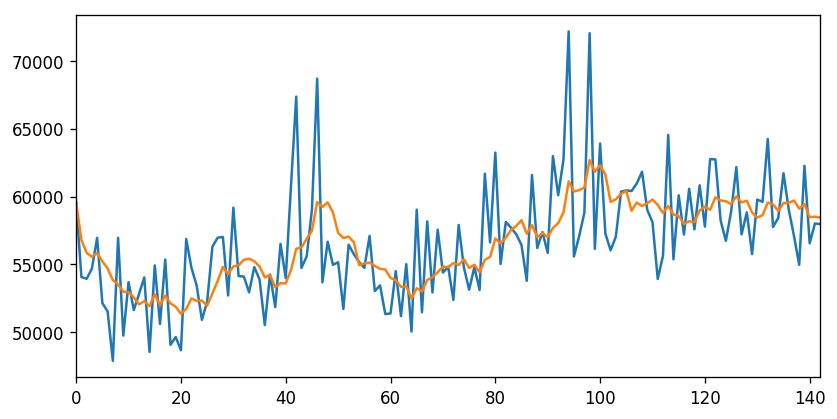

In [61]:
wal.sales.plot();
w.plot()

### Functions

In [9]:
def adfuller(data):
    dftest = sm.tsa.stattools.adfuller(data, autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

In [100]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

## Analysis

In [21]:
adfuller(y)

Test statistic = -1.990
P-value = 0.291
Critical values :
	1%: -3.480118600110386 - The data is not stationary with 99% confidence
	5%: -2.8833618426136196 - The data is not stationary with 95% confidence
	10%: -2.578407034974382 - The data is not stationary with 90% confidence


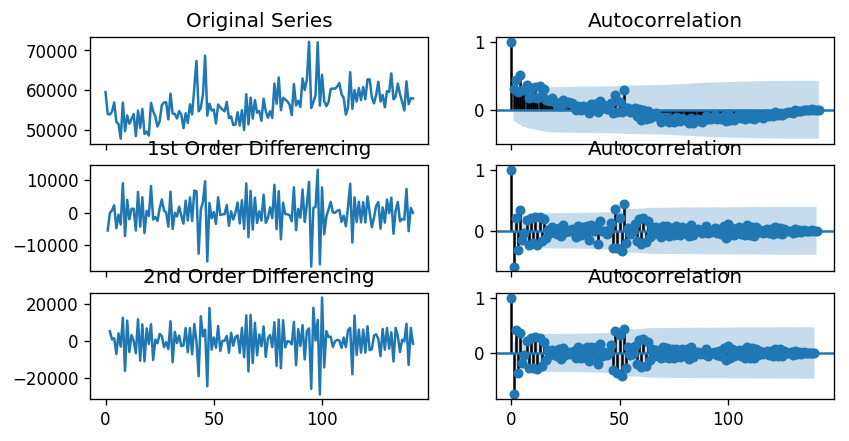

In [44]:
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(wal.sales); axes[0, 0].set_title('Original Series')
plot_acf(wal.sales, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(wal.sales.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(wal.sales.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(wal.sales.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(wal.sales.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [15]:
(ndiffs(y, test='adf'), ndiffs(y, test='kpss'), ndiffs(y, test='pp'))

(0, 1, 0)

In [63]:
model = ARIMA(y, order=(0, 1, 1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                  142
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1366.083
Method:                       css-mle   S.D. of innovations           3628.380
Date:                Tue, 18 Jun 2019   AIC                           2738.167
Time:                        12:06:18   BIC                           2747.034
Sample:                             1   HQIC                          2741.770
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            34.2449     44.023      0.778      0.438     -52.039     120.529
ma.L1.D.sales    -0.8637      0.054    -16.022      0.000      -0.969      -0.758
                                    Root

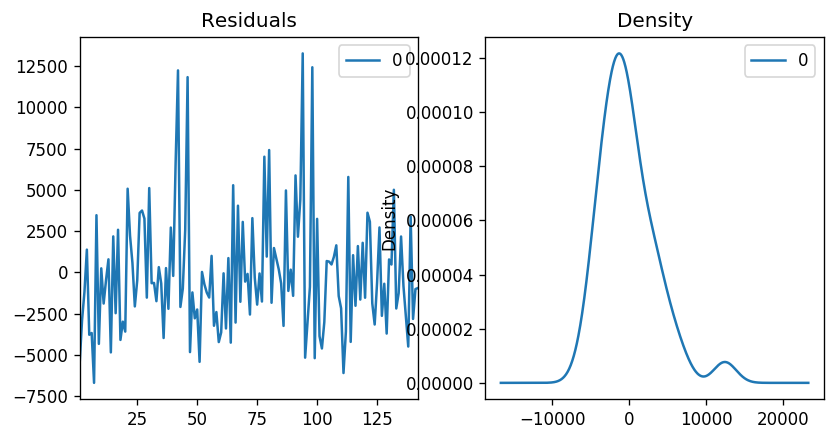

In [64]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
# AIC 2716.543 3-1-3

In [111]:
model = ARIMA(y, order=(3, 1, 3))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                  142
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1350.271
Method:                       css-mle   S.D. of innovations           3217.255
Date:                Tue, 18 Jun 2019   AIC                           2716.543
Time:                        12:19:50   BIC                           2740.189
Sample:                             1   HQIC                          2726.152
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            26.5203     59.051      0.449      0.654     -89.218     142.259
ar.L1.D.sales    -1.2241      0.104    -11.775      0.000      -1.428      -1.020
ar.L2.D.sales    -0.9419      0.138     

In [51]:
train = y[:120]
test = y[104:]

In [118]:
# model = ARIMA(train, order=(0, 1, 1))  
model = ARIMA(train, order=(3, 1, 3))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(23, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

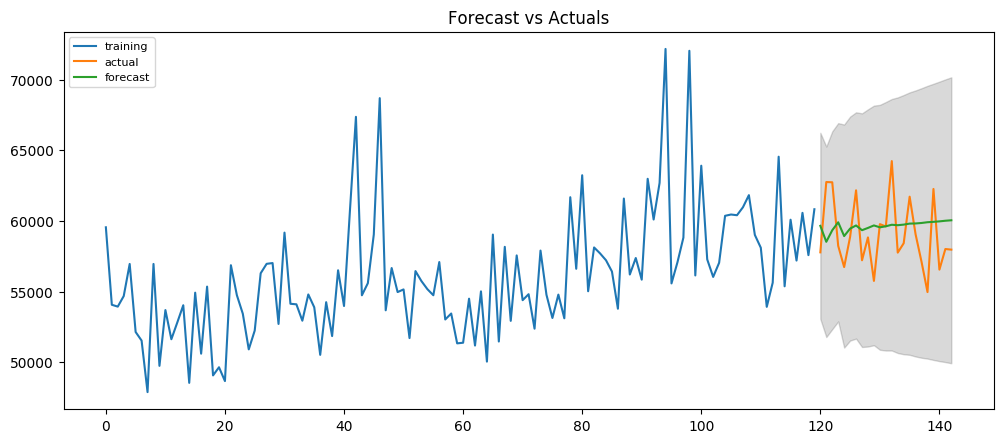

In [119]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [101]:
forecast_accuracy(fc, test.values)

{'acf1': -0.026009428352340096,
 'corr': -0.2220489846340751,
 'mae': 2300.61864687699,
 'mape': 0.03915045564949906,
 'me': 814.1118575339946,
 'minmax': 0.03778486527515024,
 'mpe': 0.015507338799561059,
 'rmse': 2637.0164811417494}

#### Auto ARIMA

In [120]:
model = pm.auto_arima(y, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Fit ARIMA: order=(1, 1, 1); AIC=2738.643, BIC=2750.466, Fit time=0.250 seconds
Fit ARIMA: order=(0, 1, 0); AIC=2824.069, BIC=2829.981, Fit time=0.007 seconds
Fit ARIMA: order=(1, 1, 0); AIC=2766.292, BIC=2775.159, Fit time=0.113 seconds
Fit ARIMA: order=(0, 1, 1); AIC=2738.167, BIC=2747.034, Fit time=0.161 seconds
Fit ARIMA: order=(0, 1, 2); AIC=2738.934, BIC=2750.757, Fit time=0.307 seconds
Fit ARIMA: order=(1, 1, 2); AIC=2736.969, BIC=2751.748, Fit time=0.422 seconds
Fit ARIMA: order=(2, 1, 2); AIC=2737.335, BIC=2755.069, Fit time=0.441 seconds
Fit ARIMA: order=(1, 1, 3); AIC=2734.221, BIC=2751.956, Fit time=0.813 seconds
Fit ARIMA: order=(0, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 3); AIC=2723.576, BIC=2744.267, Fit time=0.724 seconds
Fit ARIMA: order=(3, 1, 3); AIC=2716.543, BIC=2740.189, Fit time=0.960 seconds
Fit ARIMA: order=(3, 1, 2); AIC=2735.985, BIC=2756.675, Fit time=0.589 seconds
Total fit time: 4.797 seconds


In [121]:
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  142
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1350.271
Method:                       css-mle   S.D. of innovations           3217.255
Date:                Tue, 18 Jun 2019   AIC                           2716.543
Time:                        12:22:06   BIC                           2740.189
Sample:                             1   HQIC                          2726.152
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.5203     59.051      0.449      0.654     -89.218     142.259
ar.L1.D.y     -1.2241      0.104    -11.775      0.000      -1.428      -1.020
ar.L2.D.y     -0.9419      0.138     -6.847      0.0

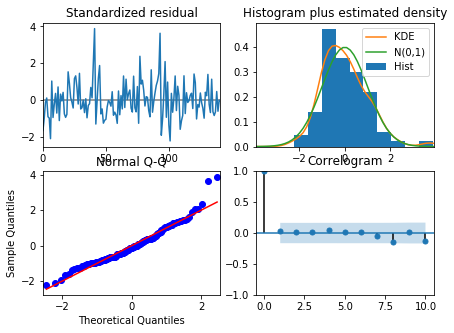

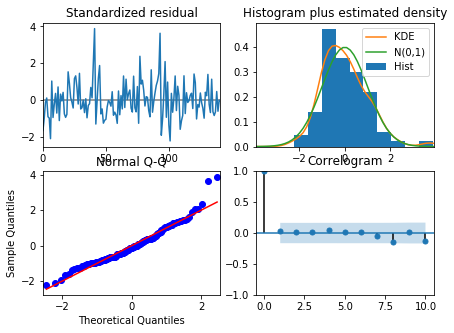

In [122]:
model.plot_diagnostics(figsize=(7,5))

### SARIMA

In [128]:
smodel = pm.auto_arima(y, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=52,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=1734.437, BIC=1739.437, Fit time=0.631 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=1712.574, BIC=1722.573, Fit time=7.187 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=1712.412, BIC=1719.911, Fit time=1.297 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=1715.713, BIC=1725.712, Fit time=1.938 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 52); AIC=1716.823, BIC=1726.823, Fit time=2.200 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 0, 52); AIC=nan, BIC=nan, F

In [ ]:
# SARIMAX(2, 0, 1)x(0, 1, 2, 12) - 2615.463
# SARIMAX(1, 1, 0)x(0, 1, 0, 52) - 1712.412


In [129]:
print(smodel.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  143
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 52)   Log Likelihood                -853.206
Date:                            Tue, 18 Jun 2019   AIC                           1712.412
Time:                                    12:29:23   BIC                           1719.911
Sample:                                         0   HQIC                          1715.436
                                            - 143                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     32.4619    267.829      0.121      0.904    -492.473     557.397
ar.L1         -0.3207      0.019   

In [139]:
predict = smodel.fit_predict(train, n_periods=23)

In [141]:
predict_series = pd.Series(predict, index=test.index)

In [146]:
# Holt-Winters

model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=52)
fit = model.fit()
wal_exp = fit.forecast(23)

In [147]:
exp_series = pd.Series(wal_exp, index=test.index)

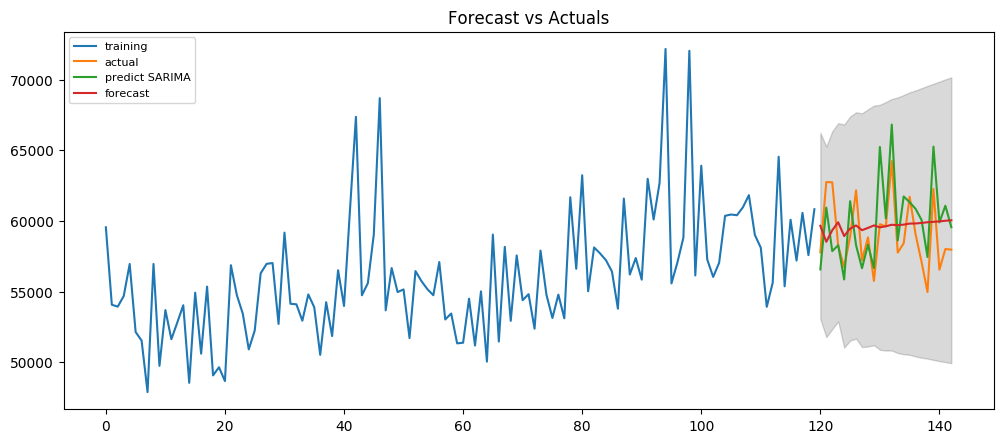

In [142]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(predict_series, label='predict SARIMA')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

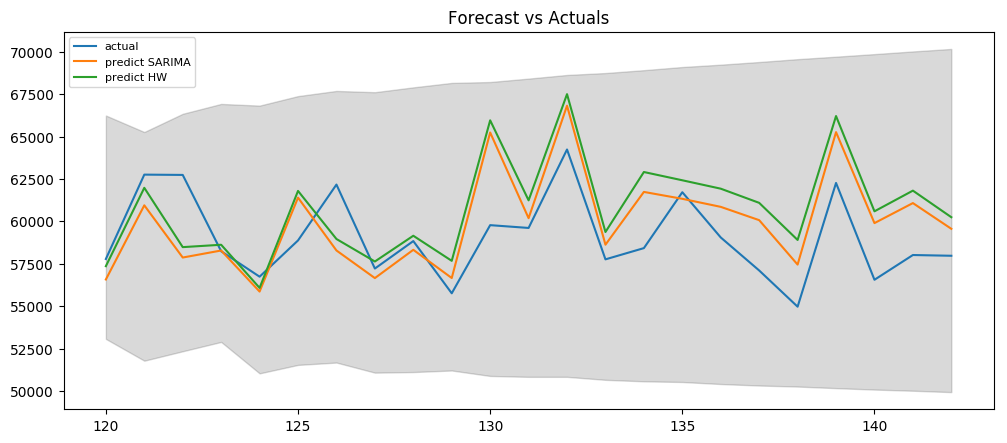

In [148]:
# Plot exp_series
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test, label='actual')
plt.plot(predict_series, label='predict SARIMA')
plt.plot(exp_series, label='predict HW')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [149]:
# SARIMA

forecast_accuracy(predict_series, test.values)

{'acf1': -0.04382570083769111,
 'corr': 0.5905755452446187,
 'mae': 2114.939534773107,
 'mape': 0.03557581388364176,
 'me': 886.9299717338034,
 'minmax': 0.03431906116201089,
 'mpe': 0.015550542561665992,
 'rmse': 2563.6989332891458}

In [150]:
# Holt-Winters

forecast_accuracy(exp_series, test.values)

{'acf1': -0.04382570083769111,
 'corr': 0.5735556100067966,
 'mae': 2522.4147123588436,
 'mape': 0.04266572944697163,
 'me': 1711.0372079365,
 'minmax': 0.040557224478086074,
 'mpe': 0.029545978048814155,
 'rmse': 3008.5880848470733}